(100, 100)
[7.22831632e-15 6.49054646e-01 2.46330160e+00 4.25654515e+00
 4.78210877e+00 4.88096047e+00 6.24057948e+00 6.77121703e+00
 6.93258243e+00 7.35061310e+00 7.74837526e+00 7.96861492e+00
 8.08999915e+00 8.15509212e+00 8.30078105e+00 8.45311539e+00
 8.71689986e+00 8.79940012e+00 8.81735444e+00 8.95620118e+00
 9.03473870e+00 9.14218637e+00 9.36730648e+00 9.44048334e+00
 9.51842168e+00 9.66173907e+00 9.82588934e+00 9.88453134e+00
 1.00534096e+01 1.00856525e+01 1.02129719e+01 1.03341106e+01
 1.05460749e+01 1.06032675e+01 1.06666476e+01 1.09328967e+01
 1.11914457e+01 1.17530266e+01 1.19489197e+01 1.23018429e+01
 1.24108115e+01 1.24696085e+01 1.27076223e+01 1.30255360e+01
 1.31543951e+01 1.31724161e+01 1.33465477e+01 1.33728523e+01
 1.37359186e+01 1.40420964e+01 1.44513223e+01 1.45521510e+01
 1.46451238e+01 1.46836739e+01 1.47982906e+01 1.51312740e+01
 1.57406313e+01 1.58941372e+01 1.64788222e+01 1.64994340e+01
 1.65520724e+01 1.67357683e+01 1.71209800e+01 1.72849757e+01
 1.73130261e+

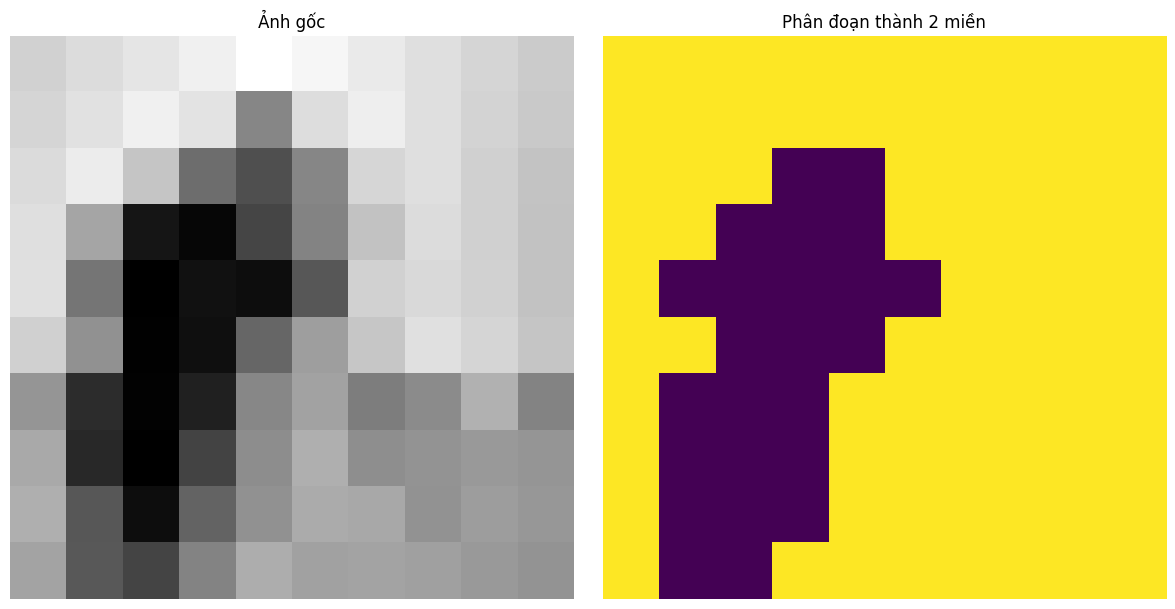

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Hàm k-means tự cài ---
def kmeans(X, n_clusters, max_iter=100, tol=1e-4):
    """
    Phân cụm k-means trên dữ liệu X (shape: [N, d]).
    Trả về nhãn (labels) cho từng điểm và các tâm cụm.
    """
    N, d = X.shape
    # Khởi tạo ngẫu nhiên các tâm cụm từ dữ liệu
    indices = np.random.choice(N, n_clusters, replace=False)
    centroids = X[indices, :]
    
    for i in range(max_iter):
        # Gán nhãn cho từng điểm dựa trên tâm cụm gần nhất
        dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(dists, axis=1)
        # Cập nhật các tâm cụm
        new_centroids = np.array([X[labels==j].mean(axis=0) if np.any(labels==j) else centroids[j]
                                  for j in range(n_clusters)])
        # Kiểm tra hội tụ
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels, centroids

# --- Hàm phân đoạn ảnh bằng spectral clustering ---
def spectral_clustering_segmentation(img_path, resized_dim=(32, 32), n_clusters=4, sigma_s=3.0, sigma_I=0.1):
    """
    Phân đoạn ảnh thành nhiều miền bằng spectral clustering.
    
    Tham số:
      - img_path: đường dẫn ảnh.
      - resized_dim: kích thước ảnh sau khi resize.
      - n_clusters: số miền cần phân đoạn.
      - sigma_s: tham số cho khoảng cách không gian.
      - sigma_I: tham số cho cường độ ảnh.
    """
    # Bước 1: Load, chuyển sang grayscale và resize ảnh
    img = Image.open(img_path).convert("L")
    img = img.resize(resized_dim)
    img = np.array(img, dtype=np.float64) / 255.0  # chuẩn hóa về [0, 1]
    
    n_rows, n_cols = img.shape
    N = n_rows * n_cols
    
    # Bước 2: Tạo vector đặc trưng cho mỗi pixel: [x, y, intensity]
    x_coords, y_coords = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
    x_coords = x_coords.ravel()
    y_coords = y_coords.ravel()
    intensity = img.ravel()
    
    spatial_features = np.column_stack((x_coords, y_coords))
    intensity_features = intensity.reshape(-1, 1)
    
    # Bước 3: Tính ma trận affinity W với kernel Gaussian
    # Tính khoảng cách không gian giữa các pixel
    diff_spatial = spatial_features[:, np.newaxis, :] - spatial_features[np.newaxis, :, :]
    dist_spatial_sq = np.sum(diff_spatial**2, axis=2)
    
    # Tính hiệu cường độ giữa các pixel
    diff_intensity = intensity_features - intensity_features.T
    dist_intensity_sq = diff_intensity**2
    
    # Ma trận affinity
    W = np.exp(- dist_spatial_sq / (2 * sigma_s**2) - dist_intensity_sq / (2 * sigma_I**2))
    
    # Bước 4: Tính ma trận bậc D và Laplacian L
    D = np.diag(W.sum(axis=1))
    L = D - W
    np.savetxt('L.txt', L, fmt='%f')
    print(L.shape)
    # Bước 5: Tính eigen-decomposition của L
    # Vì L đối xứng nên sử dụng np.linalg.eigh (trả về eigenvalue theo thứ tự tăng dần)
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    print(eigenvalues)
    # Lưu ý: Với đồ thị liên thông, eigenvalue nhỏ nhất (thường =0) có vector riêng hằng.
    # Để phân đoạn thành nhiều miền, ta lấy các vector riêng không tầm thường.
    if n_clusters > 1:
        # Lấy các vector riêng thứ 2 đến n_clusters (tương ứng với n_clusters-1 vector)
        # Một số nguồn cũng lấy cả vector riêng đầu tiên nhưng vì nó hằng nên không phân biệt được.
        features_for_clustering = eigenvectors[:, 1:n_clusters]
    else:
        features_for_clustering = eigenvectors[:, 0].reshape(-1, 1)
    
    # Bước 6: Chuẩn hóa các vector đặc trưng (mỗi hàng) về độ dài đơn vị
    norm = np.linalg.norm(features_for_clustering, axis=1, keepdims=True)
    norm[norm == 0] = 1  # tránh chia cho 0
    features_normalized = features_for_clustering / norm
    
    # Bước 7: Phân cụm bằng thuật toán k-means trên không gian eigen (features_normalized)
    labels, centroids = kmeans(features_normalized, n_clusters)
    
    segmented_image = labels.reshape(n_rows, n_cols)
    
    # Bước 8: Hiển thị kết quả
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Ảnh gốc")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title(f"Phân đoạn thành {n_clusters} miền")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return segmented_image

# --- Ví dụ sử dụng ---
# Thay đổi đường dẫn "your_image.png" thành đường dẫn ảnh của bạn
img_path = "cameraman.jpg"  
segmented = spectral_clustering_segmentation(img_path, resized_dim=(10, 10),
                                             n_clusters=2, sigma_s=3.0, sigma_I=0.1)
